**Preprocess - parse XML**

use BeautifulSoup to parse XML file, output with pandas dataframe "sentence, E#A, sentiment"

In [17]:
from bs4 import BeautifulSoup
import pandas as pd
with open("./data/Laptops_Train_p1.xml") as Laptops_Train_p1:
    soup = BeautifulSoup(Laptops_Train_p1, "xml")
#print(soup.prettify())

In [21]:
# Create empty lists to store the extracted data
sentence_ids = []
texts = []
categories = []
polarities = []

# Loop through the 'sentence' elements and extract the necessary information
for sentence in soup.find_all('sentence'):
    sentence_ids.append(sentence['id'])
    texts.append(sentence.find('text').text)
    opinions = sentence.find('Opinions')
    if opinions is not None:
        s_categories = []
        s_polarities = []
        for opinion in opinions.find_all('Opinion'):
            s_categories.append(opinion['category'])
            s_polarities.append(opinion['polarity'])
        categories.append(",".join(s_categories))
        polarities.append(",".join(s_polarities))
    else:
        categories.append(None)
        polarities.append(None)

# Create a pandas dataframe from the extracted data
df = pd.DataFrame({'Sentence ID': sentence_ids,
                   'Text': texts,
                   'Categories': categories,
                   'Polarities': polarities})
print(df)

                          Sentence ID  \
0                                79:0   
1                                79:1   
2                                79:2   
3                                79:3   
4                                79:4   
...                               ...   
2495  B00KMRGF28_143_A2F0D5EV8ZOK44:1   
2496  B00KMRGF28_143_A2F0D5EV8ZOK44:2   
2497  B00KMRGF28_143_A2F0D5EV8ZOK44:3   
2498  B00KMRGF28_302_A149BES2K4UIY1:0   
2499  B00KMRGF28_302_A149BES2K4UIY1:1   

                                                   Text  \
0                     Being a PC user my whole life....   
1                This computer is absolutely AMAZING!!!   
2                           10 plus hours of battery...   
3     super fast processor and really nice graphics ...   
4     and plenty of storage with 250 gb(though I wil...   
...                                                 ...   
2495                        It does what it advertises.   
2496  Price is great, wish it didn'

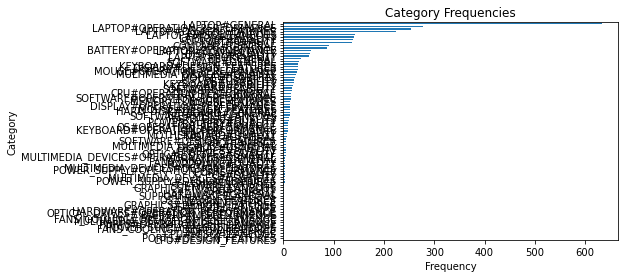

In [25]:
# Data analysis
import matplotlib.pyplot as plt

# Split categories and create new rows
df_copy = df.copy()
split_categories = df_copy['Category'].str.split(',')
df_copy = df_copy.assign(Category=split_categories).explode('Category')

# Get the unique categories and their frequencies
category_counts = df_copy['Category'].value_counts()
#top_categories = category_counts.head(50)

# Plot the frequencies in descending order
category_counts.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Category Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Category')
plt.show()

**Preprocess - tokenisation, lemmenti,...**

**Preprocess - encoding**

**Model - Max Entropy Classifier with threshold t**